

# Loan Default Probability Predictor


## 1. Load dataset

**Import the libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from pickle import dump
from pickle import load

**Read in the data** 

In [17]:
# Read the large CSV file (this might take a minute or two)
#df = pd.read_csv('data/loan_data.csv')

# Save the DataFrame to a pickle file
#df.to_pickle('data/loan_data_pickle.pkl')

# Read the DataFrame from a pickle file (this takes a few seconds)
df = pd.read_pickle('data/loan_data_pickle.pkl')

In [3]:
# make sure nothing's being truncated
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [114]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [74]:
print('dataset dimension: ',df.shape)
df.head()

dataset dimension:  (1646801, 150)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0.0,Aug-1994,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,0.00,0.00,17392.37,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-2016,12017.81,NaN,Nov-2017,684.0,680.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,149140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500.0,NaN,NaN,NaN,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0.0,Sep-1989,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,0.00,0.00,6611.69,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-2016,321.08,NaN,Feb-2017,564.0,560.0,0.0,59.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,162110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [160]:
print('dataset columns: ',df.columns)

dataset columns:  Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
      

## 2. EDA + Data Preparation pt.1 -- Target variable

In [4]:
# We're going to try to predict the loan_status. Let's take a closer look at this variable.
df['loan_status'].value_counts(dropna=False)

loan_status
Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: count, dtype: int64

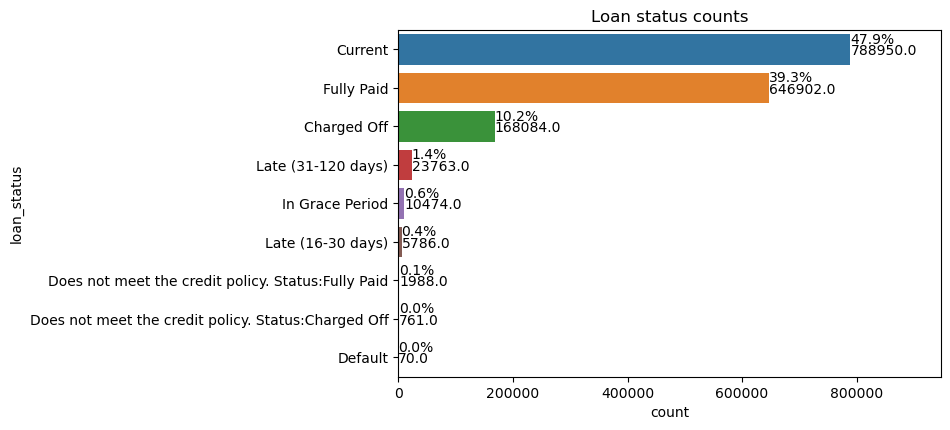

In [90]:
loan_status_order = df['loan_status'].value_counts().index

plt.figure(figsize=(7,4.5))
ax = sns.countplot(y='loan_status', data=df, order=loan_status_order)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_width()/len(df['loan_status'])), (p.get_width()+1, (p.get_y() + p.get_height()/2)-0.15))
    ax.annotate(f'{p.get_width()}', (p.get_width()+1, (p.get_y() + p.get_height()/2)+0.15))
ax.set_xlim(0, df['loan_status'].value_counts().max() * 1.2)
plt.title("Loan status counts")
plt.show()

We're only going to look at completed loans that are either "Fully Paid" or "Charged Off"/"Default". This means, we'll only keep the rows where loan_status is one of "Fully Paid", "Charged Off", or "Default".

A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. The predicted variable takes value 1 in case of charge-off or default and 0 otherwise (fully paid).

In [115]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

# Prepare our target variable by adding a 'defaulted' column
df['defaulted'] = (df['loan_status'].isin(['Charged Off', 'Default'])).apply(np.float64)
df.drop('loan_status', axis=1, inplace=True)

print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 150)


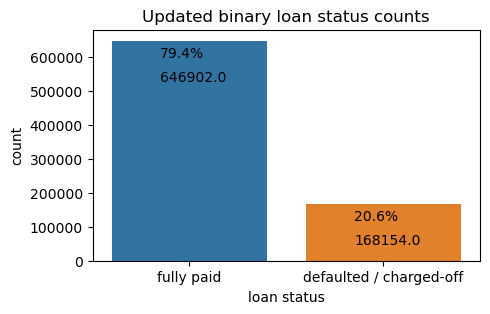

In [113]:
plt.figure(figsize=(5,3))

ax = sns.countplot(x='defaulted', data=df)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df['defaulted'])), (p.get_x()+0.25, p.get_height()-50000))
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()-120000))

plt.title("Updated binary loan status counts")
plt.xlabel("loan status")
plt.xticks([0,1],["fully paid", "defaulted / charged-off"])
plt.show()

We see that about 80% of the loans are fully paid and about 20% have charged off / defaulted, giving us a **somewhat** unbalanced classification problem.


## 3. EDA + Data Preparation pt.2 -- Feature selection

**3.1 Missing Values in features**

In [130]:
perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print('fraction of missing values features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('\n\n data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

print('\n\n percentage of data with missing values:',perc_data_has_missing) # returning 1 -- meaning that all datapoints contain some missing values in features

fraction of missing values features:
member_id                                     100.000000
emp_title                                       5.959591
emp_length                                      5.184306
desc                                           85.310089
title                                           0.971835
dti                                             0.004417
inq_last_6mths                                  0.000123
mths_since_last_delinq                         51.187035
mths_since_last_record                         83.539781
revol_util                                      0.060119
last_pymnt_d                                    0.180233
next_pymnt_d                                   99.991412
last_credit_pull_d                              0.004785
collections_12_mths_ex_med                      0.006871
mths_since_last_major_derog                    74.795351
annual_inc_joint                               99.535983
dti_joint                                      99.5

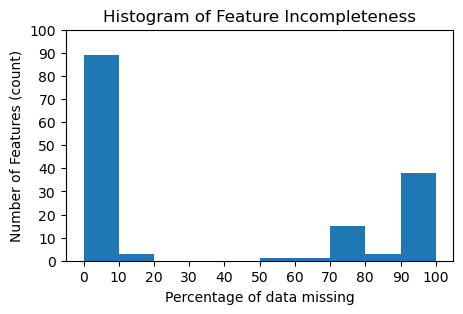

In [129]:
perc_missing_per_ftr = perc_missing_per_ftr.sort_values(ascending=False)

plt.figure(figsize=(5,3))
perc_missing_per_ftr.plot.hist(bins=10)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Percentage of data missing')
plt.ylabel('Number of Features (count)')
plt.xticks(np.arange(0, 105, 10))
plt.yticks(np.arange(0, 110, 10));

In [133]:
small_frac_missing_ftr = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr < 20].index))
mid_frac_missing_ftr = sorted(list(perc_missing_per_ftr[(perc_missing_per_ftr >= 20) & (perc_missing_per_ftr <= 50)].index))
large_frac_missing_ftr = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr > 50].index))
print("Features with < 20%   missing data : ", len(small_frac_missing_ftr),' i.e.', np.around(len(small_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')
print("Features with 20%-50% missing data : ", len(mid_frac_missing_ftr), '  i.e.', np.around(len(mid_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')
print("Features with > 50%   missing data : ", len(large_frac_missing_ftr),' i.e.', np.around(len(large_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')

Features with < 20%   missing data :  92  i.e. 61.33 % of total features
Features with 20%-50% missing data :  0   i.e. 0.0 % of total features
Features with > 50%   missing data :  58  i.e. 38.67 % of total features


Here we see that about 60% features have <20% missing data, and the rest 40% have >50% missing data. Since we have a relatively large dataset, we'll still be able to keep the diversity of our dataset as well as many useful information needed in our classification task. Hence, we can eliminate those features with a large fraction of missing values.  

**3.2 Select Features**

Since we have 150 features here, in order to save computing power, we'll only keep the most relevant features to feed into our ML model. Features will be selected based on the following criteria:
- Eliminate features with > 20% missing values.
- Eliminate features that are not available to investors when making investment decisions.
- Eliminate features with low correlation with the target variable "defaulted", and one of the features fully correlated with each other.

**3.2.1 eliminate features with >20% missing values**

Most of these removed features include the term 'joint' (e.g., dti_joint), indicating that we are primarily removing features associated with loans that have co-borrowers. However, we are retaining features related to single borrowers. This is actually beneficial for us, ensuring that our processed dataset remains IID (independently and identically distributed).

Another common theme among the removed features is a shared 'heading' (e.g., hardship_xxx). This means that we are omitting only certain features describing a particular attribute, while still preserving the rest, thereby retaining the essential information we require.

In [134]:
drop_list = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr > 20].index))
print(drop_list)
print('\n\n dropped number of features: ',len(drop_list))

df.drop(labels=drop_list, axis=1, inplace=True)
print('\n\n dataset dimension: ',df.shape)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

**3.2.2 eliminate features that are not available to investors when making investment decisions**

There's no better way to do this rather than going through the feature description and manually deciding which features would have been available to potential investors before an investment decision was made. 

In [135]:
# current feature list
print('# features: ',len(df.columns))
print('features sorted in alphabetical order: ',sorted(df.columns))

# features decided to keep:
keep_list = ['acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'defaulted', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'open_acc', 'out_prncp', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'total_pymnt', 'total_rec_int', 'verification_status', 'zip_code']
print('\n\n # features kept: ',len(keep_list))

# drop the other features
drop_list = [col for col in df.columns if col not in keep_list]
df.drop(labels=drop_list, axis=1, inplace=True)
print('\n\n dataset dimension: ',df.shape)

# features:  92
features sorted in alphabetical order:  ['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'defaulted', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_re

**3.2.3 eliminate features with low correlation with the target variable "defaulted", and one of the features fullt correlated with each other.**

In [136]:
# calculate the correlation
float_features = df.select_dtypes(include=['float64'])
correlation = float_features.corr()

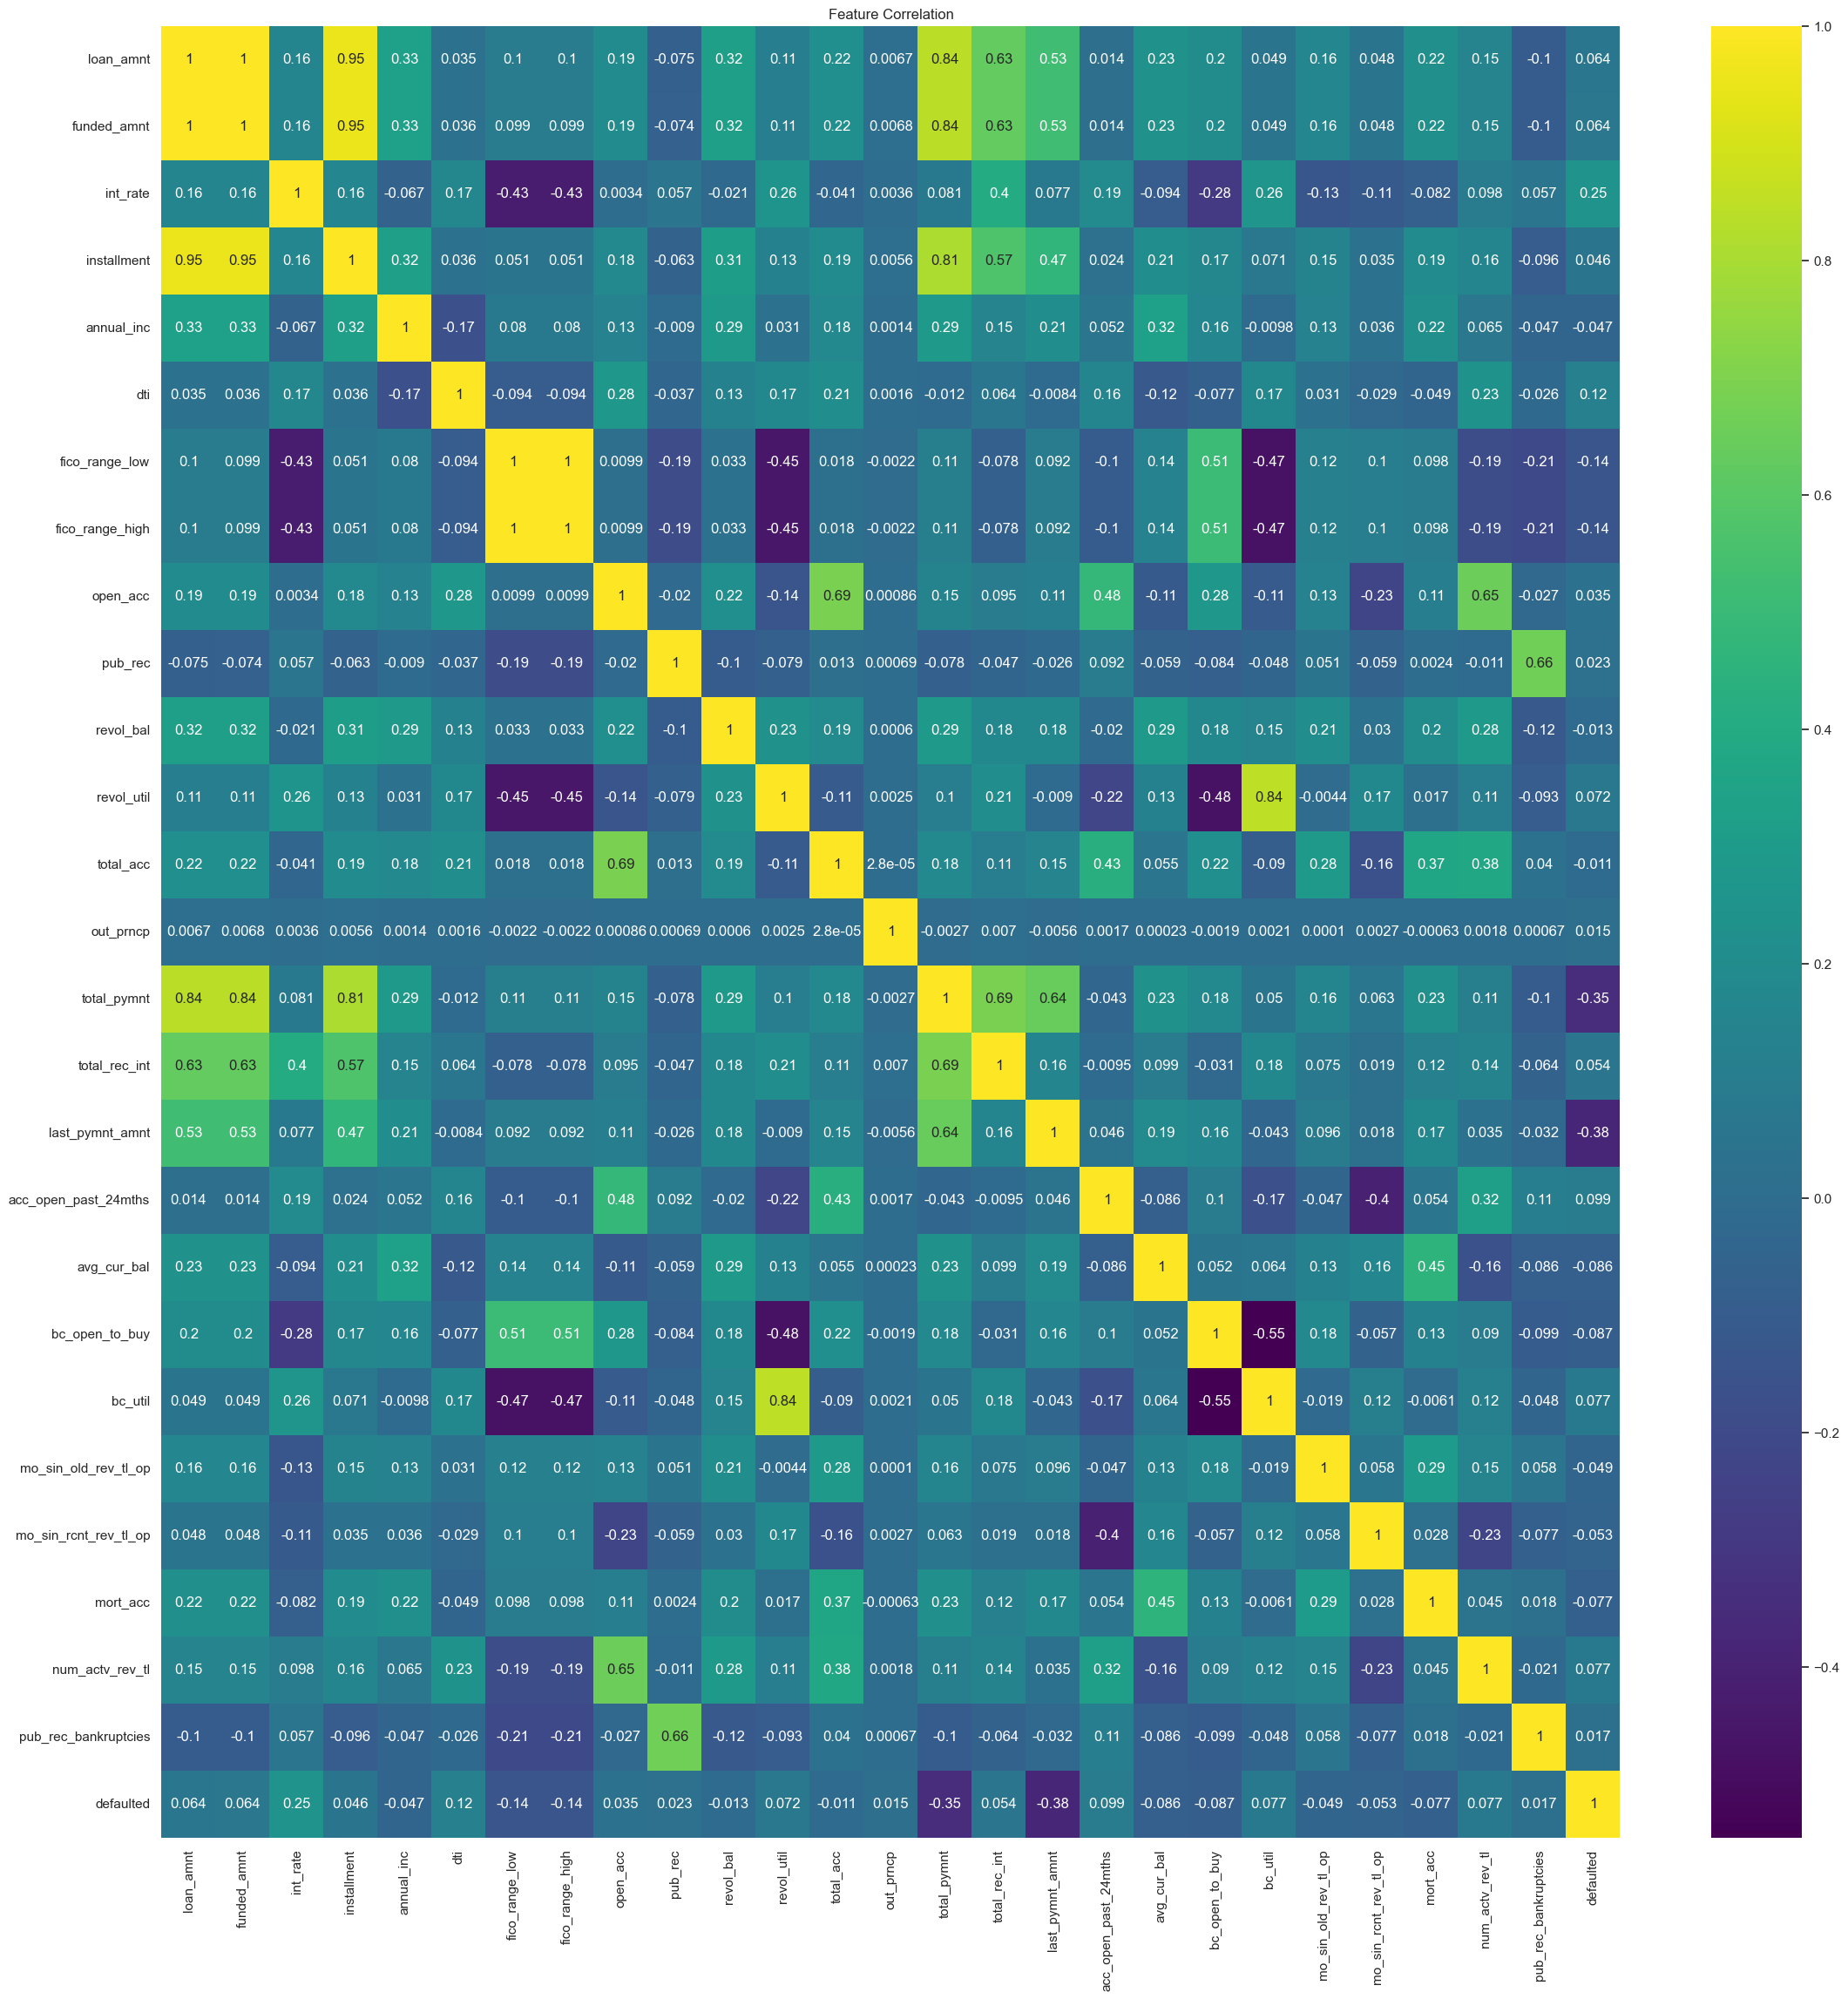

In [83]:
plt.figure(figsize=(27,27))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Feature Correlation');

We see that some features are fully correlated with each other, so we need to remove one in each pair to reduce the risk of overfitting and save computational resources.

- loan_amnt, funded_amnt: remove funded_amnt
- fico_range_high and fico_range_low: create a new feature averaging the two instead of keeping both

In [137]:
df.drop(['funded_amnt'], axis=1, inplace=True)

df['fico_score'] = 0.5*df['fico_range_low'] + 0.5*df['fico_range_high']
df.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 40)


In [85]:
# recalculate the correlation
float_features = df.select_dtypes(include=['float64'])
correlation = float_features.corr()

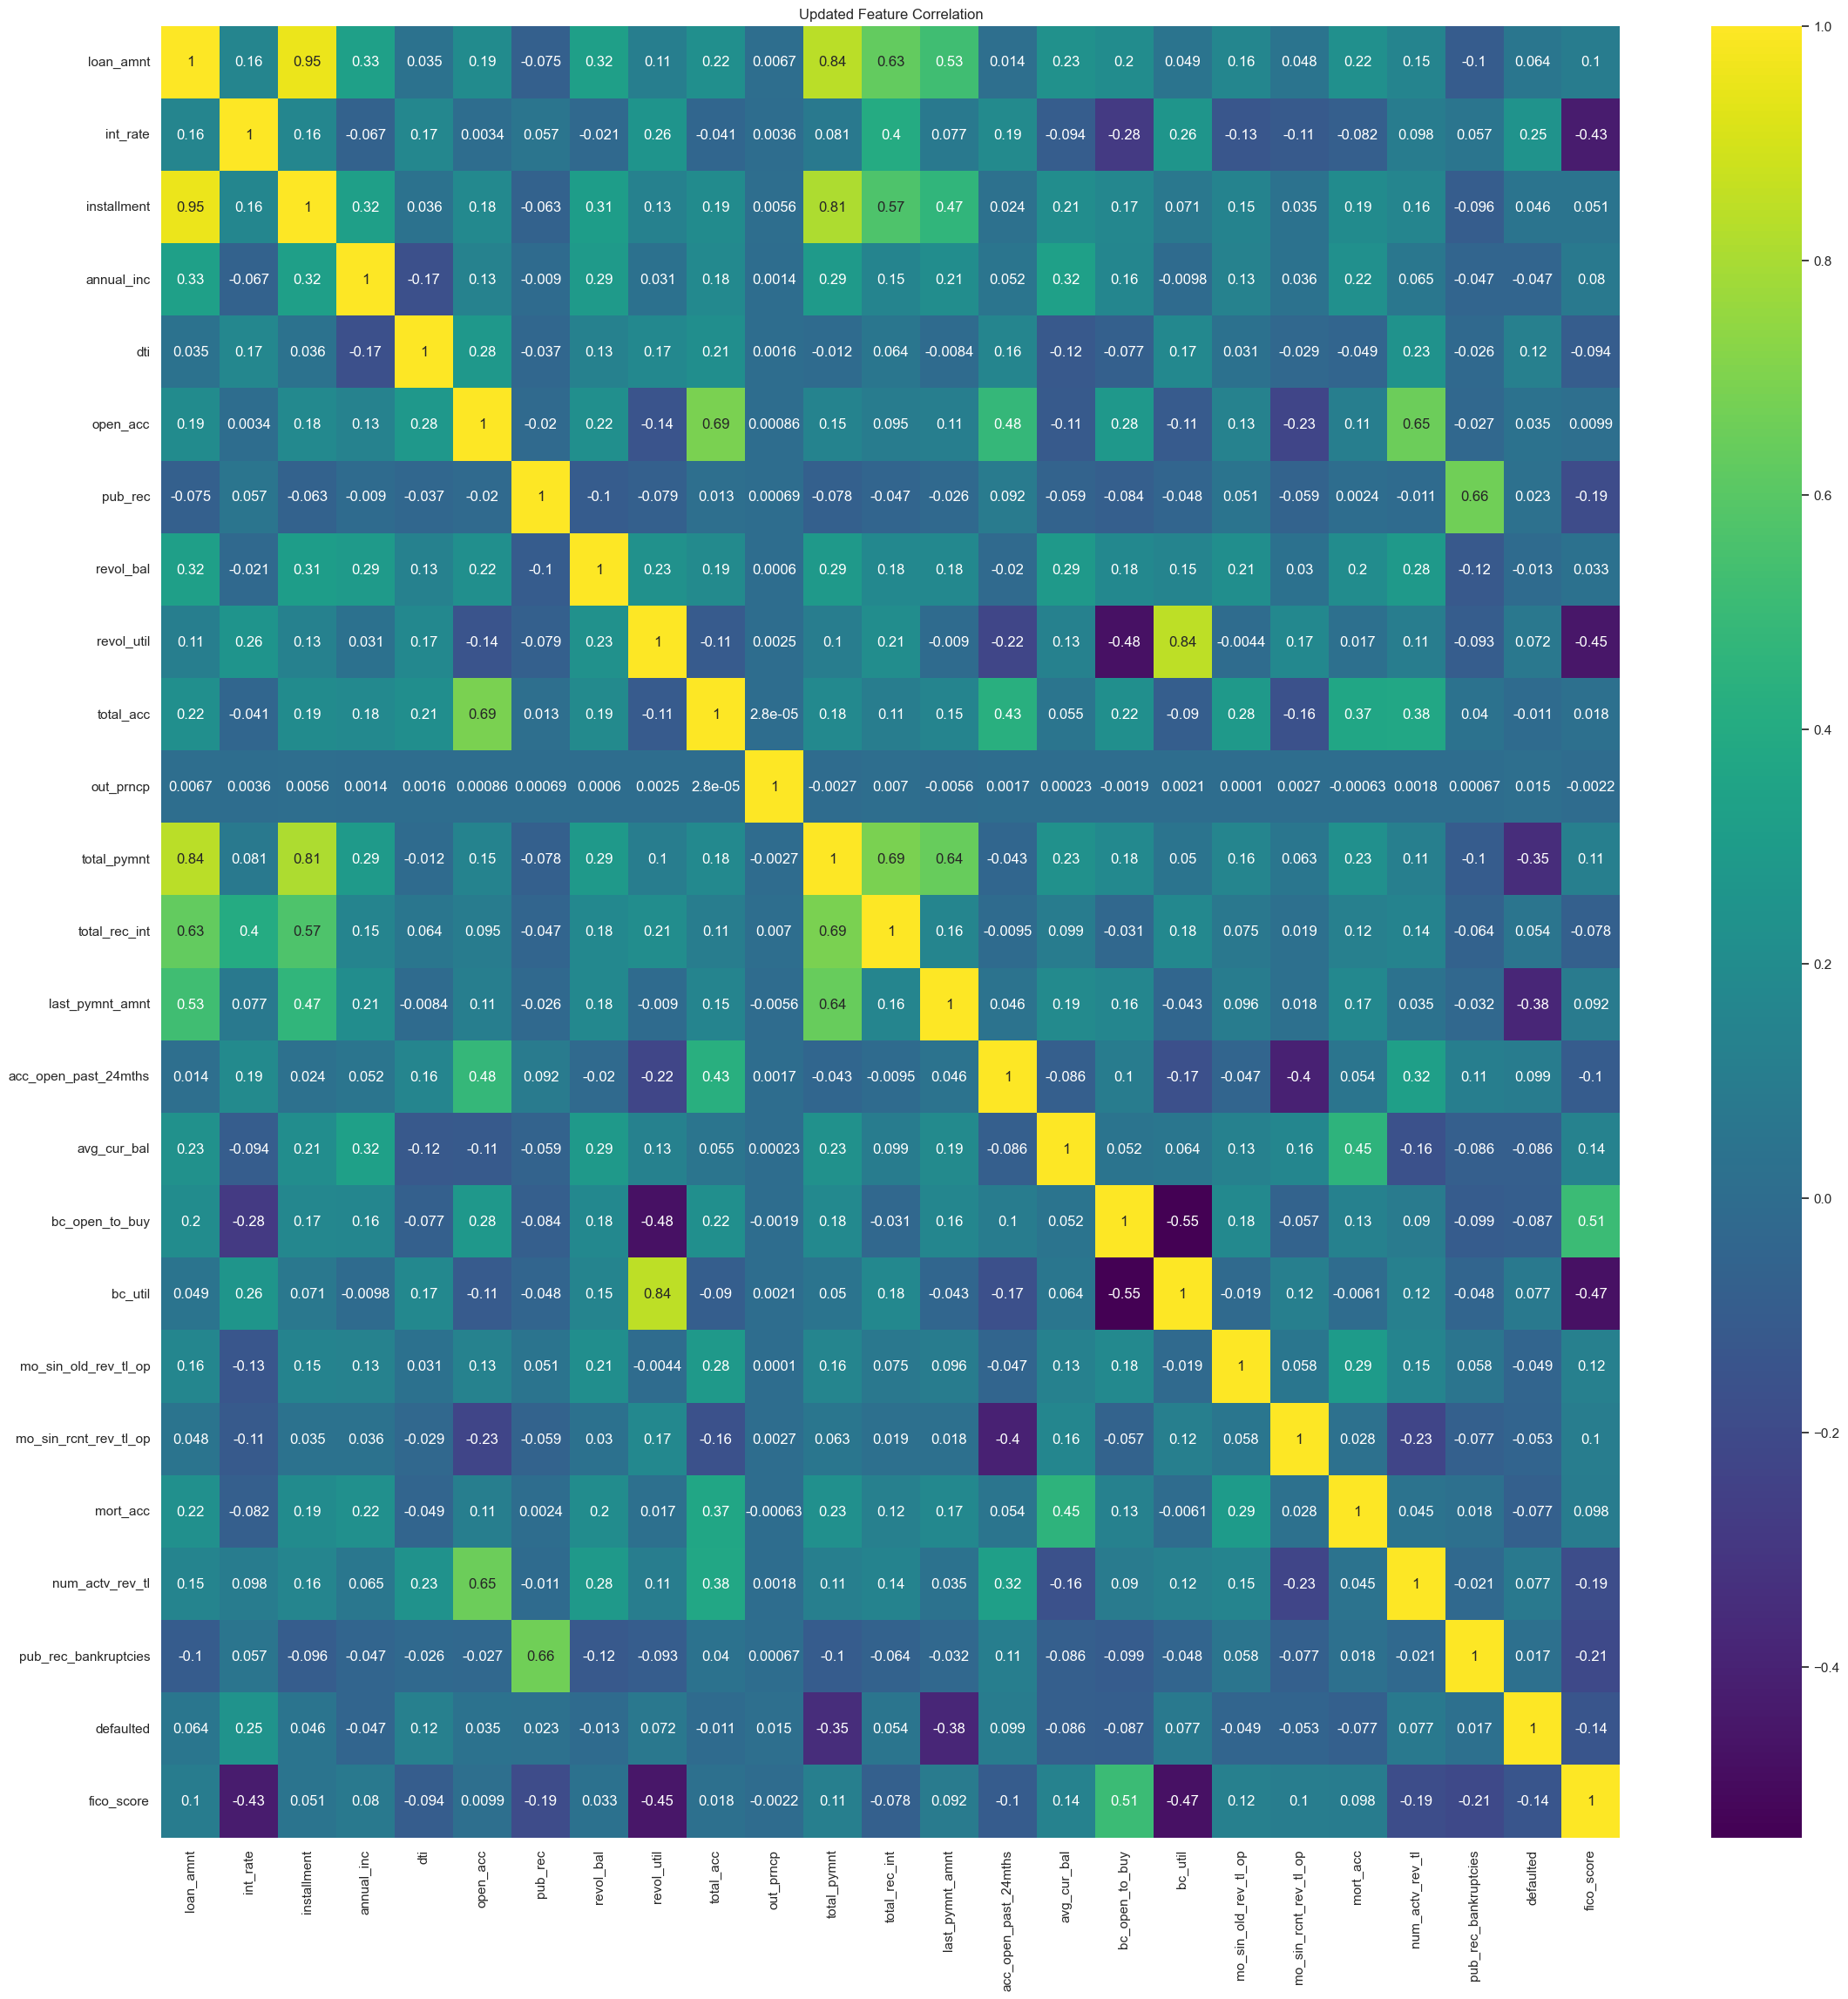

In [86]:
plt.figure(figsize=(27,27))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Updated Feature Correlation');

In [139]:
correlation_defaulted = abs(correlation['defaulted']).sort_values(ascending=False)
print(correlation_defaulted)

defaulted                1.000000
last_pymnt_amnt          0.381411
total_pymnt              0.350998
int_rate                 0.247824
fico_range_low           0.139471
fico_range_high          0.139470
dti                      0.123057
acc_open_past_24mths     0.099007
bc_open_to_buy           0.086927
avg_cur_bal              0.085786
num_actv_rev_tl          0.077226
bc_util                  0.077168
mort_acc                 0.077101
revol_util               0.072213
funded_amnt              0.064280
loan_amnt                0.064161
total_rec_int            0.053620
mo_sin_rcnt_rev_tl_op    0.053411
mo_sin_old_rev_tl_op     0.048513
annual_inc               0.046680
installment              0.046310
open_acc                 0.034675
pub_rec                  0.023115
pub_rec_bankruptcies     0.017334
out_prncp                0.014772
revol_bal                0.013156
total_acc                0.011180
Name: defaulted, dtype: float64


In [140]:
# we decide to drop the last few features with a correlation value <0.015
drop_list_corr = sorted(list(correlation_defaulted[correlation_defaulted < 0.015].index))
print(drop_list_corr)

df.drop(labels=drop_list_corr, axis=1, inplace=True)
print('dataset dimension: ',df.shape)

['out_prncp', 'revol_bal', 'total_acc']
dataset dimension:  (815056, 37)


In [143]:
# % feature with missing value in updated feature list 

perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print('percentage of missing values features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('\n\n data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

print('\n\n percentage of data with missing values:',perc_data_has_missing)

percentage of missing values features:
emp_title                5.959591
emp_length               5.184306
title                    0.971835
dti                      0.004417
revol_util               0.060119
acc_open_past_24mths     5.800951
avg_cur_bal              8.286424
bc_open_to_buy           6.769842
bc_util                  6.829837
mo_sin_old_rev_tl_op     8.285075
mo_sin_rcnt_rev_tl_op    8.285075
mort_acc                 5.800951
num_actv_rev_tl          8.284952
pub_rec_bankruptcies     0.085516
dtype: float64


 data types of the features with missing values:
emp_title                 object
emp_length                object
title                     object
dti                      float64
revol_util               float64
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mort_acc                 float64
num_actv_rev_tl        

In [144]:
# Save the DataFrame to a pickle file so that we can directly load from here nexttime
#df.to_pickle('data/selected_loan_data_pickle.pkl')

df = pd.read_pickle('data/selected_loan_data_pickle.pkl')
print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 37)


## 4. EDA + Data Preparation pt.3 -- Feature Format Cleaning

**4.1 Categorical & Ordinal Features**

In [94]:
categorical_cols = df.columns[df.dtypes==object].tolist()
print(categorical_cols)

['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']


In [95]:
df[categorical_cols].describe()

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
count,815056,815056,815056,815056,766482,772801,815056,815056,815056,807135,815056,815056,815056,815056,815056
unique,815056,2,7,35,280488,11,6,3,14,60297,925,51,712,2,2
top,38098114,36 months,B,B3,Teacher,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,945xx,CA,Aug-2001,f,Individual
freq,1,618505,235239,51312,11351,264889,406893,293928,481692,371912,9517,124211,6025,413693,811274


In [96]:
df[categorical_cols].head(5)

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,38098114,60 months,C,C1,MANAGEMENT,10+ years,RENT,Source Verified,debt_consolidation,Debt consolidation,235xx,VA,Aug-1994,w,Individual
1,36805548,36 months,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,Not Verified,credit_card,Credit card refinancing,937xx,CA,Sep-1989,w,Individual
2,37842129,60 months,D,D1,Programming Analysis Supervisor,6 years,RENT,Source Verified,credit_card,Credit card refinancing,658xx,MO,Aug-2003,w,Individual
4,37662224,36 months,C,C3,Technical Specialist,< 1 year,RENT,Source Verified,debt_consolidation,Debt consolidation,850xx,AZ,Aug-2002,f,Individual
5,37822187,36 months,C,C3,Admin Specialist,10+ years,RENT,Source Verified,debt_consolidation,Debt consolidation,077xx,NJ,Nov-1992,f,Individual


**4.1.1 Categorical Feature Selection**

In [97]:
df[['id','emp_title','title','zip_code']].describe()

,id,emp_title,title,zip_code
count,815056,766482,807135,815056
unique,815056,280488,60297,925
top,38098114,Teacher,Debt consolidation,945xx
freq,1,11351,371912,9517


We see that IDs are all unique and it's meant to be used as a identification metric for loans. This also verifies that this dataset is i.i.d. distributed. This will not be useful in predicting loan default probabilities, so we could drop the ID column.

Also, there are too many unique categories for job titles of the borrower ('emp_title'), loan titles ('title'), and borrower zipcode (zip_code). They will create trouble when we later preprocess our categorical features. We could also go about dropping them.

In [145]:
df.drop(['id','emp_title','title','zip_code'], axis=1, inplace=True)

**4.1.2 Categorical & Ordinal Feature Format Cleaning**

- **"term" feature**
    - Feature description: "The number of payments on the loan. Values are in months and can be either 36 or 60."
    - We see from the description above that this feature has 2 unique categories and is not yet formated as an integer. We'll now correctly format this feature so that we can use it later in our ML model.


In [209]:
# clean term feature by removing "month" from the input and cast it to an integer
df['term'] = df['term'].apply(lambda s: np.int64(s.split()[0]))

term
36    0.165771
60    0.333878
Name: proportion, dtype: float64


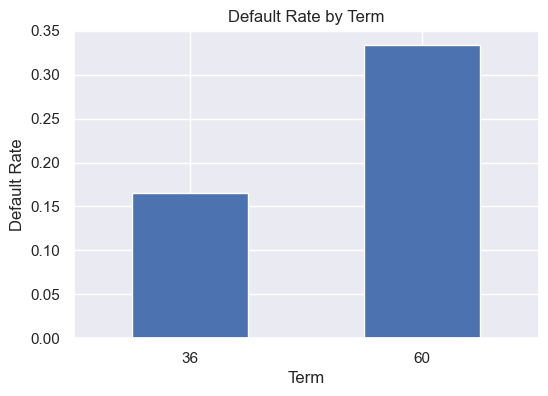

In [212]:
# Now let's do some visualization on this

term_groups = df.groupby('term')['defaulted'].value_counts(normalize=True).loc[:,1]
print(term_groups)

plt.figure(figsize=(6,4))
term_groups.plot.bar()
plt.title('Default Rate by Term')
plt.xlabel('Term')
plt.ylabel('Default Rate')
plt.xticks(rotation=0)
plt.show()

We see that Loans with a five-year term (60 months) are more than twice as likely to charge-off / default as loans with a three-year term (36 months).

- **"earliest_cr_line" feature**
    - Feature description: "The month the borrower's earliest reported credit line was opened."
    - We see from the description above that this feature comes in MM-YYYY is not yet formated as a float. We'll now correctly format this feature and just keep the year, so that we can use it later in our ML model.


In [210]:
# clean feature by removing month from the input and cast it to a int
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda s: int(s[-4:]))

count    815056.000000
mean       1998.171036
std           7.385698
min        1944.000000
25%        1994.000000
50%        2000.000000
75%        2003.000000
max        2014.000000
Name: earliest_cr_line, dtype: float64


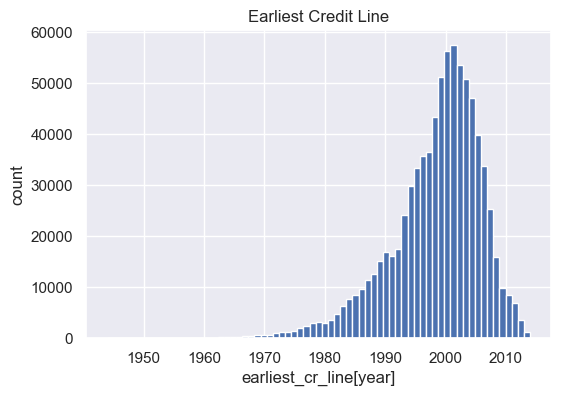

In [103]:
# Now let's do some visualization on this

print(df['earliest_cr_line'].describe())

plt.figure(figsize=(6,4))
df['earliest_cr_line'].plot.hist(bins = df['earliest_cr_line'].nunique())   
plt.title('Earliest Credit Line')
plt.xlabel('earliest_cr_line[year]') 
plt.ylabel('count')
plt.show()

After reformatting, this feature is now essentially a continuous feature.

- **"emp_length" feature**
    - Feature description: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. "

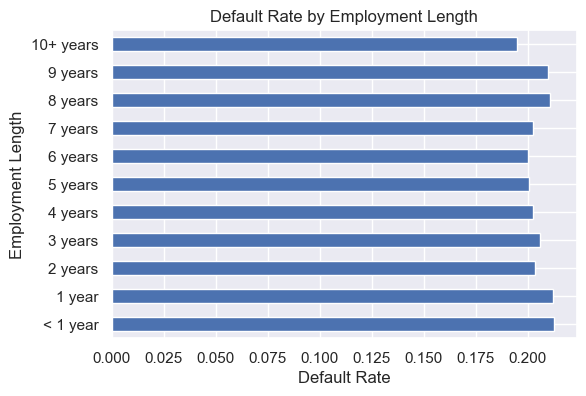

In [117]:
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
emp_len_group_default_rates = df.groupby('emp_length')['defaulted'].value_counts(normalize=True).loc[:,1]
plt.figure(figsize=(6,4))
emp_len_group_default_rates.reindex(order).plot.barh()
plt.title('Default Rate by Employment Length')
plt.ylabel('Employment Length')
plt.xlabel('Default Rate')
plt.show()

We see that the the loan default rate does not appear to vary much with employment length on average, hence we can drop this feature.

In [146]:
df.drop(['emp_length'], axis=1, inplace=True)

**4.1.3 Continuous Feature Format Cleaning**

- **"annual_inc" feature**
    - Feature description: "The self-reported annual income provided by the borrower during registration."

In [106]:
df[['annual_inc']].describe()

,annual_inc
count,8.150560e+05
mean,7.523024e+04
std,6.524262e+04
min,0.000000e+00
25%,4.500000e+04
50%,6.500000e+04
75%,9.000000e+04
max,9.550000e+06


Annual income ranges from 0  to  9,550,000, with a median of $65,000. This feature has a very large range compared to other features in our dataset. Hence, we will do a log transformation to compensate for the large range here.

In [213]:
df['log_annual_inc'] = df['annual_inc'].apply(lambda x: np.log10(x+1))
df.drop('annual_inc', axis=1, inplace=True)

In [147]:
# Save the DataFrame to a pickle file so that we can directly load from here nexttime
#df.to_pickle('data/cleaned_loan_data_pickle.pkl')

df = pd.read_pickle('data/cleaned_loan_data_pickle.pkl')
print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 32)


## 5. EDA on Cleaned Dataset

**5.1 General patterns**

In [129]:
print('dataset dimension: ',df.shape)
df.head(10)

dataset dimension:  (815056, 32)


,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_util,initial_list_status,total_pymnt,total_rec_int,last_pymnt_amnt,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,defaulted,fico_score,log_annual_inc
0,15000.0,60.0,12.39,336.64,C,C1,RENT,Source Verified,debt_consolidation,VA,12.03,1994,6.0,0.0,29.0,w,17392.37,2392.37,12017.81,Individual,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0.0,0.0,752.0,4.892100
1,10400.0,36.0,6.99,321.08,A,A3,MORTGAGE,Not Verified,credit_card,CA,14.92,1989,17.0,0.0,31.6,w,6611.69,872.67,321.08,Individual,7.0,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,0.0,1.0,712.0,4.763435
2,21425.0,60.0,15.59,516.36,D,D1,RENT,Source Verified,credit_card,MO,18.49,2003,10.0,0.0,76.2,w,25512.20,4087.20,17813.19,Individual,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0.0,0.0,687.0,4.804827
4,7650.0,36.0,13.66,260.20,C,C3,RENT,Source Verified,debt_consolidation,AZ,34.81,2002,11.0,0.0,91.9,f,2281.98,339.61,17.70,Individual,6.0,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,0.0,1.0,687.0,4.698979
5,9600.0,36.0,13.66,326.53,C,C3,RENT,Source Verified,debt_consolidation,NJ,25.81,1992,12.0,0.0,59.4,f,9973.43,373.43,9338.58,Individual,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0.0,0.0,682.0,4.838855
6,2500.0,36.0,11.99,83.03,B,B5,MORTGAGE,Source Verified,home_improvement,MN,13.77,2001,9.0,0.0,94.3,f,2622.22,122.22,2294.26,Individual,6.0,44136.0,1333.0,86.4,148.0,24.0,5.0,4.0,0.0,0.0,687.0,4.949395
7,16000.0,60.0,11.44,351.40,B,B4,OWN,Verified,debt_consolidation,VA,11.63,2003,7.0,0.0,60.4,w,18586.72,2586.72,4935.54,Individual,3.0,53392.0,2559.0,72.2,133.0,17.0,2.0,3.0,0.0,0.0,702.0,5.040515
8,23325.0,36.0,14.31,800.71,C,C4,RENT,Source Verified,credit_card,WA,27.03,1998,14.0,0.0,82.2,f,13907.79,3061.64,800.71,Individual,6.0,39356.0,3977.0,89.0,194.0,15.0,6.0,5.0,0.0,1.0,667.0,4.857339
9,5250.0,36.0,11.44,172.98,B,B4,RENT,Not Verified,debt_consolidation,MD,14.36,2009,8.0,0.0,20.2,f,5431.68,181.68,43.40,Individual,4.0,1267.0,12152.0,26.8,67.0,12.0,0.0,2.0,0.0,0.0,747.0,4.414990
10,10000.0,36.0,11.99,332.10,B,B5,RENT,Verified,debt_consolidation,MI,8.44,2003,5.0,0.0,98.0,f,6957.45,1562.16,332.10,Individual,0.0,4745.0,324.0,98.5,124.0,40.0,0.0,5.0,0.0,1.0,677.0,4.954247


In [130]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 815056 entries, 0 to 1646792
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              815056 non-null  float64
 1   term                   815056 non-null  float64
 2   int_rate               815056 non-null  float64
 3   installment            815056 non-null  float64
 4   grade                  815056 non-null  object 
 5   sub_grade              815056 non-null  object 
 6   home_ownership         815056 non-null  object 
 7   verification_status    815056 non-null  object 
 8   purpose                815056 non-null  object 
 9   addr_state             815056 non-null  object 
 10  dti                    815020 non-null  float64
 11  earliest_cr_line       815056 non-null  int64  
 12  open_acc               815056 non-null  float64
 13  pub_rec                815056 non-null  float64
 14  revol_util             814566 non-null  

In [131]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,815056.0,14315.614602,8499.899175,500.00,8000.000000,12000.00000,20000.000000,40000.000000
term,815056.0,41.787607,10.266757,36.00,36.000000,36.00000,36.000000,60.000000
int_rate,815056.0,13.491135,4.618476,5.32,9.990000,13.11000,16.290000,30.990000
installment,815056.0,436.753460,255.733916,4.93,251.400000,377.04000,576.290000,1714.540000
dti,815020.0,17.867952,8.856468,-1.00,11.640000,17.36000,23.630000,999.000000
earliest_cr_line,815056.0,1998.171036,7.385698,1944.00,1994.000000,2000.00000,2003.000000,2014.000000
open_acc,815056.0,11.521184,5.325193,0.00,8.000000,11.00000,14.000000,90.000000
pub_rec,815056.0,0.205738,0.584937,0.00,0.000000,0.00000,0.000000,86.000000
revol_util,814566.0,53.031671,24.320963,0.00,35.000000,53.70000,71.900000,892.300000
total_pymnt,815056.0,14418.305421,10049.909811,0.00,6683.110000,11928.33238,19997.945130,61557.694036


In [132]:
duplicate = df.duplicated()
print('Number of duplicated rows: ',duplicate.sum())

Number of duplicated rows:  0


In [148]:
perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print('percentage of missing values features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('\n\n data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

print('\n\n percentage of data with missing values:',perc_data_has_missing)

percentage of missing values features:
dti                      0.004417
revol_util               0.060119
acc_open_past_24mths     5.800951
avg_cur_bal              8.286424
bc_open_to_buy           6.769842
bc_util                  6.829837
mo_sin_old_rev_tl_op     8.285075
mo_sin_rcnt_rev_tl_op    8.285075
mort_acc                 5.800951
num_actv_rev_tl          8.284952
pub_rec_bankruptcies     0.085516
dtype: float64


 data types of the features with missing values:
dti                      float64
revol_util               float64
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mort_acc                 float64
num_actv_rev_tl          float64
pub_rec_bankruptcies     float64
dtype: object


 percentage of data with missing values: 9.283411201193537


**5.2 Categorical & Ordinal Features**

In [206]:
categorical_cols = df.columns[df.dtypes==object].tolist()
categorical_cols.append('term')
print(categorical_cols)
df[categorical_cols].describe()

['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'term']


,term
count,815056.000000
mean,41.787607
std,10.266757
min,36.000000
25%,36.000000
50%,36.000000
75%,36.000000
max,60.000000


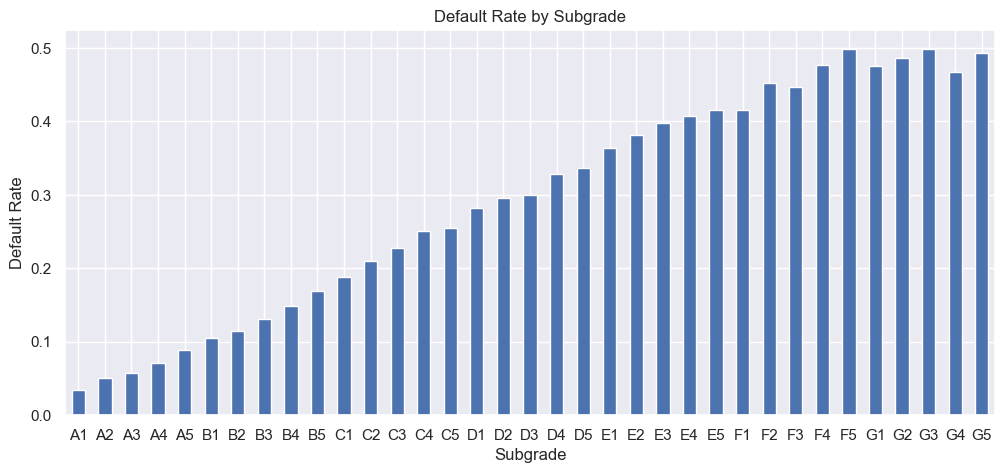

In [58]:
# subgrade

subgrade_default_rates = df.groupby('sub_grade')['defaulted'].value_counts(normalize=True).loc[:,1]
subgrade_default_rates.plot.bar()
plt.title('Default Rate by Subgrade')
plt.xlabel('Subgrade')
plt.ylabel('Default Rate')
plt.xticks(rotation=0)
plt.show()


There's a clear trend of higher probability of default / charged-off as the loan subgrade worsens.

defaulted          0.0    1.0
home_ownership               
ANY                 78     16
MORTGAGE        334522  72371
NONE                39      7
OTHER              117     27
OWN              64904  17868
RENT            247242  77865


 defaulted            0.0       1.0
home_ownership                    
ANY             0.829787  0.170213
MORTGAGE        0.822138  0.177862
NONE            0.847826  0.152174
OTHER           0.812500  0.187500
OWN             0.784130  0.215870
RENT            0.760494  0.239506


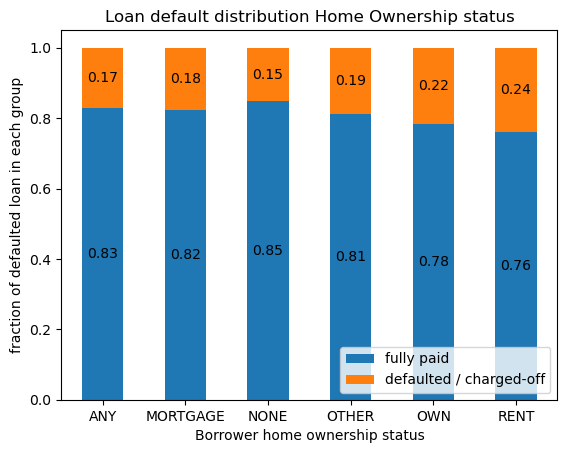

In [150]:
# home_ownership

count_matrix = df.groupby(['home_ownership', 'defaulted']).size().unstack()
print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print('\n\n', count_matrix_norm)

ax = count_matrix_norm.plot(kind='bar', stacked=True)

for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        ax.text(x, y, f"{height:.2f}", ha='center', va='center')

plt.title('Loan default distribution Home Ownership status')
plt.ylabel('fraction of defaulted loan in each group')
plt.xlabel('Borrower home ownership status')
plt.xticks(rotation=0)
plt.legend(['fully paid', 'defaulted / charged-off'],loc=4)
plt.show()

There seems to be some difference in loan default rates by loan borrower's home ownership status. Renters and homeowners have a higher probability of defaulting, while those not owning a home have lower chance of defaulting. It's interesting to see that home owners have high default rate, as they are expected to have more stable financials.

verification_status
Not Verified       0.152264
Source Verified    0.220319
Verified           0.241354
Name: proportion, dtype: float64


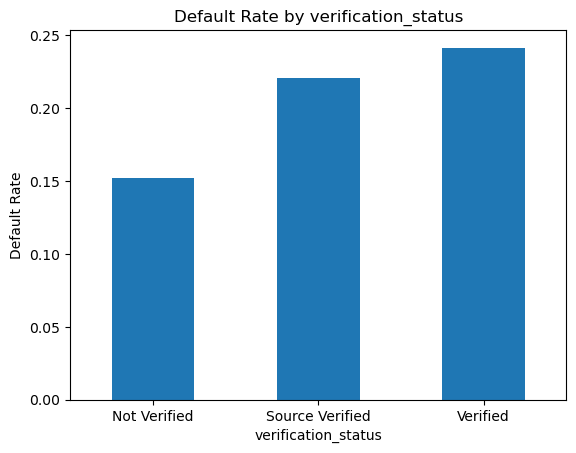

In [155]:
# verification_status

verification_status_default_rates = df.groupby('verification_status')['defaulted'].value_counts(normalize=True).loc[:,1]
print(verification_status_default_rates)

verification_status_default_rates.plot.bar()

plt.title('Default Rate by verification_status')
plt.xlabel('verification_status')
plt.ylabel('Default Rate')
plt.xticks(rotation=0)
plt.show()

We see that borrowers whose income was not verified by "Lending Club", surprisingly, have a lower default rate than those who have their income or income source verified.

In [170]:
# purpose
df.groupby('purpose')['defaulted'].value_counts(normalize=True).loc[:,1].sort_values()

purpose
wedding               0.121919
car                   0.148053
educational           0.171779
credit_card           0.178496
home_improvement      0.181399
major_purchase        0.183432
vacation              0.198788
house                 0.214844
other                 0.217077
debt_consolidation    0.217463
medical               0.229366
moving                0.242969
renewable_energy      0.247078
small_business        0.302428
Name: proportion, dtype: float64

In [172]:
# addr_state
df.groupby('addr_state')['defaulted'].value_counts(normalize=True).loc[:,1].sort_values()

addr_state
DC    0.130378
ME    0.136564
NH    0.142781
IA    0.142857
VT    0.149225
OR    0.152909
CO    0.158266
WA    0.166630
KS    0.171126
SC    0.172880
WI    0.175395
MT    0.177759
WY    0.178142
UT    0.179176
WV    0.182457
CT    0.183880
GA    0.191348
MA    0.193060
IL    0.193302
ID    0.193487
RI    0.194009
CA    0.198348
AZ    0.199321
TX    0.202396
AK    0.204141
HI    0.204535
DE    0.206575
VA    0.207976
MI    0.208994
MN    0.210418
PA    0.214833
MD    0.214928
NC    0.215351
NJ    0.216287
KY    0.216353
MO    0.219461
FL    0.222061
OH    0.225430
NM    0.225694
SD    0.225787
NY    0.227161
IN    0.228241
TN    0.230479
NV    0.234202
ND    0.237232
LA    0.237900
AR    0.243154
AL    0.247723
OK    0.248355
NE    0.268466
MS    0.275619
Name: proportion, dtype: float64

**5.3 Continuous Features**

In [202]:
continuous_cols = df.columns[df.dtypes!=object].tolist()
continuous_cols.remove('term')
print(continuous_cols)
df[continuous_cols].describe()

['loan_amnt', 'int_rate', 'installment', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'pub_rec_bankruptcies', 'defaulted', 'fico_score', 'log_annual_inc']


,loan_amnt,int_rate,installment,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_pymnt,total_rec_int,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,defaulted,fico_score,log_annual_inc
count,815056.000000,815056.000000,815056.000000,815020.000000,815056.000000,815056.000000,815056.000000,814566.000000,815056.000000,815056.000000,815056.000000,767775.000000,747517.000000,759878.000000,759389.000000,747528.000000,747528.000000,767775.000000,747529.000000,814359.000000,815056.000000,815056.000000,815056.000000
mean,14315.614602,13.491135,436.753460,17.867952,1998.171036,11.521184,0.205738,53.031671,14418.305421,2258.775746,5917.679793,4.716250,13519.560676,9464.595573,61.576414,180.843425,12.705935,1.758671,5.658926,0.132012,0.206310,697.602089,4.810833
std,8499.899175,4.618476,255.733916,8.856468,7.385698,5.325193,0.584937,24.320963,10049.909811,2410.770350,7279.817094,3.152437,16221.578615,14575.392078,27.871025,92.193799,15.654986,2.081750,3.215860,0.375193,0.404656,31.352416,0.231896
min,500.000000,5.320000,4.930000,-1.000000,1944.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,627.000000,0.000000
25%,8000.000000,9.990000,251.400000,11.640000,1994.000000,8.000000,0.000000,35.000000,6683.110000,737.270000,446.740000,2.000000,3119.000000,1312.000000,40.800000,117.000000,4.000000,0.000000,3.000000,0.000000,0.000000,672.000000,4.653222
50%,12000.000000,13.110000,377.040000,17.360000,2000.000000,11.000000,0.000000,53.700000,11928.332380,1518.520000,2863.615000,4.000000,7508.000000,4261.000000,65.400000,164.000000,8.000000,1.000000,5.000000,0.000000,0.000000,692.000000,4.812920
75%,20000.000000,16.290000,576.290000,23.630000,2003.000000,14.000000,0.000000,71.900000,19997.945130,2863.612500,9192.372500,6.000000,18827.000000,11342.000000,86.000000,228.000000,15.000000,3.000000,7.000000,0.000000,0.000000,712.000000,4.954247
max,40000.000000,30.990000,1714.540000,999.000000,2014.000000,90.000000,86.000000,892.300000,61557.694036,26557.690000,42148.530000,56.000000,958084.000000,559912.000000,339.600000,842.000000,372.000000,51.000000,57.000000,12.000000,1.000000,847.500000,6.980003


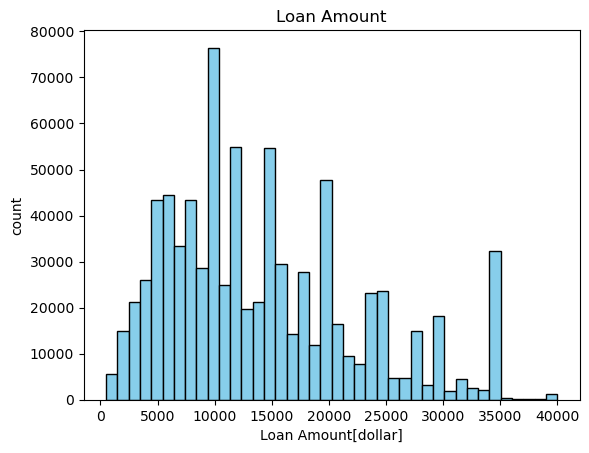

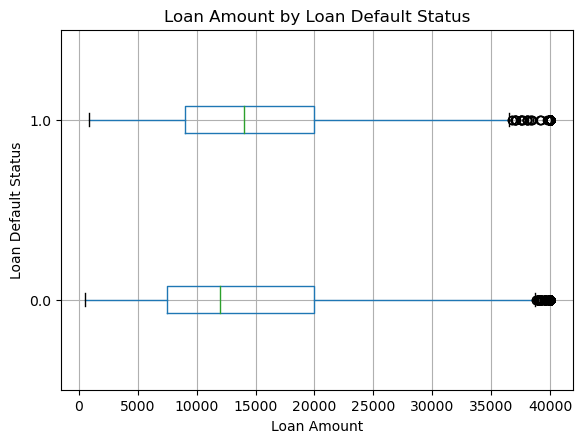

In [165]:
# loan amount

plt.hist(df['loan_amnt'],bins = 40,color='skyblue', edgecolor='black')   
plt.title('Loan Amount')
plt.xlabel('Loan Amount[dollar]') 
plt.ylabel('count')
plt.show()

df[['loan_amnt','defaulted']].boxplot(by='defaulted', vert=False)
plt.xlabel('Loan Amount')
plt.ylabel('Loan Default Status')
plt.title('Loan Amount by Loan Default Status')
plt.suptitle('')
plt.show()

Defaulted loans tend to have higher loan amounts.

In [138]:
df.groupby('defaulted')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
defaulted,,,,,,,,
0.0,646902.0,14037.566316,8449.740674,500.0,7500.0,12000.0,20000.0,40000.0
1.0,168154.0,15385.288783,8606.844046,900.0,9000.0,14000.0,20000.0,40000.0


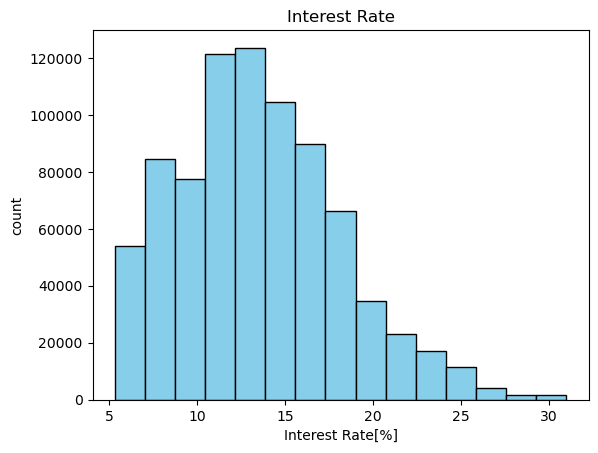

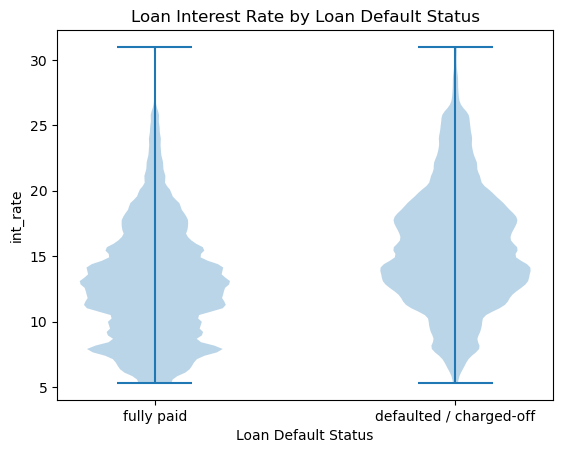

In [162]:
# interest rate

plt.hist(df['int_rate'],bins = 15,color='skyblue', edgecolor='black')   
plt.title('Interest Rate')
plt.xlabel('Interest Rate[%]') 
plt.ylabel('count')
plt.show()


dataset = [df[df['defaulted']==0.0]['int_rate'].values,
           df[df['defaulted']==1.0]['int_rate'].values]
plt.violinplot(dataset=dataset)
plt.title('Loan Interest Rate by Loan Default Status')
plt.xticks([1,2],['fully paid','defaulted / charged-off'])
plt.xlabel('Loan Default Status')
plt.ylabel('int_rate')
plt.show()

In [151]:
df['int_rate'].describe()

count    815056.000000
mean         13.491135
std           4.618476
min           5.320000
25%           9.990000
50%          13.110000
75%          16.290000
max          30.990000
Name: int_rate, dtype: float64

Defaulted loans tend to have much higher interest rates, and a loan's interest rate can range from 5.3% to up to 31%. 

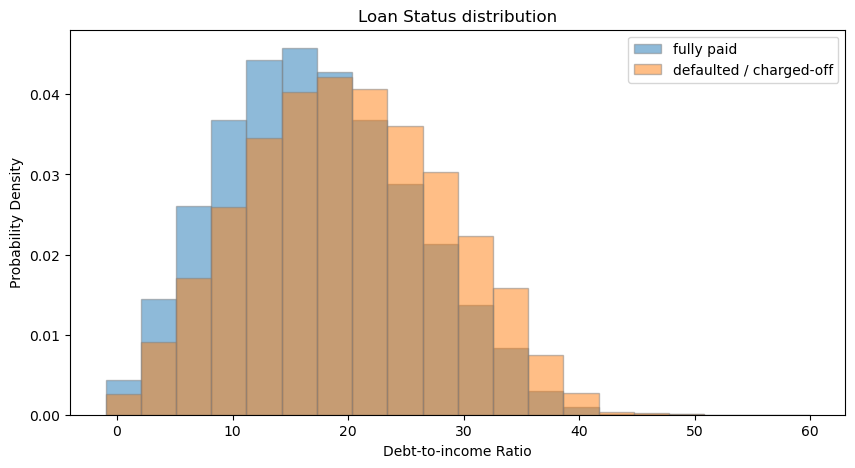

In [170]:
# dti
plt.figure(figsize=(10, 5))

categories = df['defaulted'].unique()
bin_range = (df['dti'].min(),60)

for c in categories:
    plt.hist(df[df['defaulted']==c]['dti'],alpha=0.5,label=c,range=bin_range,bins=20,edgecolor='grey',density=True)
plt.legend()
plt.ylabel('Probability Density')
plt.xlabel('Debt-to-income Ratio')
plt.title('Loan Status distribution')
plt.legend(['fully paid', 'defaulted / charged-off'])
plt.show()

Lower DTI indicaties that a smaller portion of the borrower's income is dedicated to debt payments and borrower has a good balance between income and debt.

Higher DTI shows that a larger portion of the borrower's income is committed to debt payments.This can be a warning sign that the borrower is overextended and might struggle to handle additional monthly payments or unforeseen financial hardships.

Here, distribution for borrowers of fully paid loan leans towards lower DTI, which is expected.


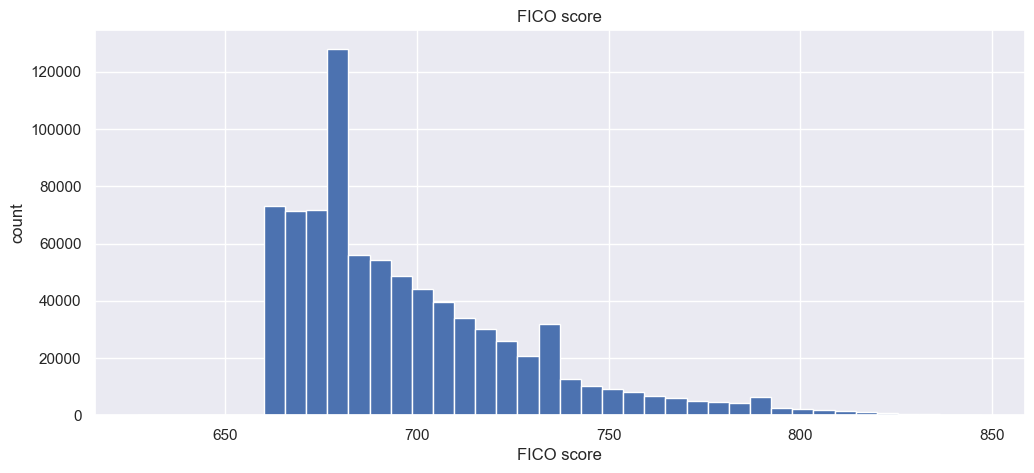

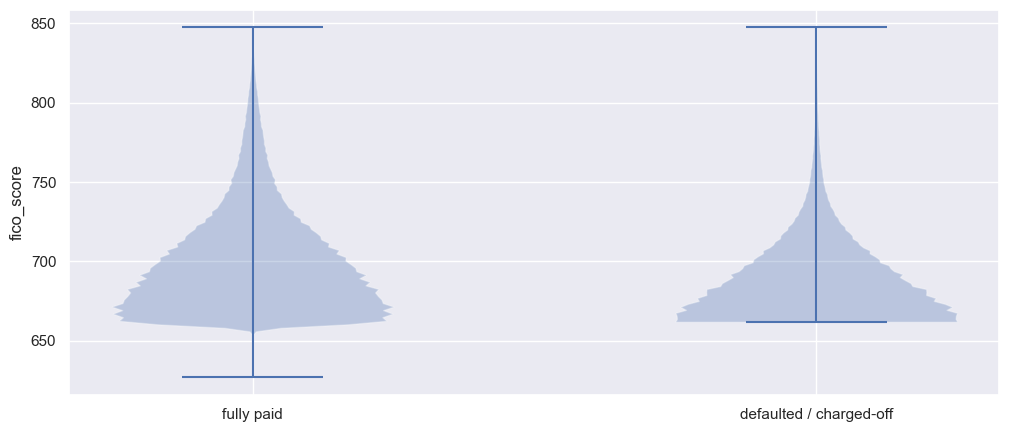

In [184]:
# fico score

plt.hist(df['fico_score'],bins = df['fico_score'].nunique())   
plt.title('FICO score')
plt.xlabel('FICO score') 
plt.ylabel('count')
plt.show()


dataset = [df[df['defaulted']==0.0]['fico_score'].values,
           df[df['defaulted']==1.0]['fico_score'].values]
plt.violinplot(dataset=dataset)
plt.xticks([1,2],['fully paid','defaulted / charged-off'])
plt.ylabel('fico_score')
plt.show()

## 6. Splitting and Preprocessing

**6.1 Splitting Dataset**

In [24]:
# Since this is a iid dataset, we can use train_test_split from scikit learn

y = df['defaulted']
X = df.loc[:, df.columns != 'defaulted']
print(X.shape)


(815056, 31)


In [25]:
# Since this is a very large dataset with 800k+ rows, we'll do 98% train， 1% val and 1% test in train-test-split

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, test_size=1/99, random_state=42)

print(X_other.shape, X_other.shape)
print('--------------------------')
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(806905, 31) (806905, 31)
--------------------------
(798754, 31) (798754,)
(8151, 31) (8151,)
(8151, 31) (8151,)


**6.2 Preprocessing (Encoding features)**

In [26]:
# collect the features
cat_ftrs = ['home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type']
ordinal_ftrs = ['grade','sub_grade']
ordinal_cats = [['A','B','C','D','E','F','G'],
                ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', \
                 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', \
                 'G1', 'G2', 'G3', 'G4', 'G5']]
max_min_ftrs =['loan_amnt','int_rate','installment','fico_score']
std_num_ftrs = ['term', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_pymnt', 'total_rec_int', \
                'last_pymnt_amnt', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op',\
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'pub_rec_bankruptcies', 'log_annual_inc']

# make sure that no features are left out
# - 1 because we excluded target variable
if (df.shape[1] - 1)==(len(cat_ftrs)+len(ordinal_ftrs)+len(max_min_ftrs)+len(std_num_ftrs)):
    print('All features collected + categorized.')

All features collected + categorized.


In [27]:
# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
# We need to replace the NaN with a string first!
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# min max scaler for numerical vals
min_max_transformer = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler())])

# standard scaler for numerical vals
numeric_transformer = Pipeline(steps=[
    ('std_scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', numeric_transformer, std_num_ftrs),
        ('minmax', min_max_transformer, max_min_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [28]:
# prepare dataset for final selected model

# fit_transform the training set
X_train_prep = preprocessor.fit_transform(X_train)

# transform the validation set
X_val_prep = preprocessor.transform(X_val)

# transform the test set
X_test_prep = preprocessor.transform(X_test)

# feature names after endoring
feature_names = preprocessor.get_feature_names_out()

# store the prepared X_train_prep, X_val_prep and X_test_prep in df for future use
df_train = pd.DataFrame(data=X_train_prep,columns=feature_names)
print('training data dimensions: ', df_train.shape)

df_val = pd.DataFrame(data=X_val_prep,columns=feature_names)
print('validation data dimensions: ', df_val.shape)

df_test = pd.DataFrame(data=X_test_prep,columns = feature_names)
print('testing data dimensions: ',df_test.shape)
print('\n\n feature names after encoding/preprocessing: ',feature_names)

/Users/cynthiax/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


training data dimensions:  (798754, 103)
validation data dimensions:  (8151, 103)
testing data dimensions:  (8151, 103)


 feature names after encoding/preprocessing:  ['std__term' 'std__dti' 'std__earliest_cr_line' 'std__open_acc'
 'std__pub_rec' 'std__revol_util' 'std__total_pymnt' 'std__total_rec_int'
 'std__last_pymnt_amnt' 'std__acc_open_past_24mths' 'std__avg_cur_bal'
 'std__bc_open_to_buy' 'std__bc_util' 'std__mo_sin_old_rev_tl_op'
 'std__mo_sin_rcnt_rev_tl_op' 'std__mort_acc' 'std__num_actv_rev_tl'
 'std__pub_rec_bankruptcies' 'std__log_annual_inc' 'minmax__loan_amnt'
 'minmax__int_rate' 'minmax__installment' 'minmax__fico_score'
 'cat__home_ownership_ANY' 'cat__home_ownership_MORTGAGE'
 'cat__home_ownership_NONE' 'cat__home_ownership_OTHER'
 'cat__home_ownership_OWN' 'cat__home_ownership_RENT'
 'cat__verification_status_Not Verified'
 'cat__verification_status_Source Verified'
 'cat__verification_status_Verified' 'cat__purpose_car'
 'cat__purpose_credit_card' 'cat__purpose_deb

In [29]:
# Save the splitted data to a pickle file so we don't need to go through the whole notebook everytime

# with open('data/prepped_data.pkl', 'wb') as f:
#     dump({
#         'X_train_prep': df_train,
#         'X_val_prep': df_val,
#         'X_test_prep': df_test,
#         'y_train_prep': y_train,
#         'y_val_prep': y_val,
#         'y_test_prep':y_test
#     }, f)


# Load the data from the pickle file

with open('data/splitted_data.pkl', 'rb') as f:
    data = load(f)
    X_train_prep = data['X_train_prep']
    X_val_prep = data['X_val_prep']
    X_test_prep = data['X_test_prep']
    y_train_prep = data['y_train_prep']
    y_val_prep = data['y_val_prep']
    y_test_prep = data['y_test_prep']

**6.3 K-Fold Validation** 

(TBD in final implementation)

Logic: 
- for every ML model, we perform a K-fold validation to calculate eval_metrics to pick the best model
- inside the kfold, for every fold, we split X_other into X_train + X_val, and fo fit_transform of our preprocessor (encoder) on X_train, transform on X_val
- so now we have for every model, for every X, y in every fold, we calculate a metric. then we avg the metrics from each fold to get the metric of this model. we compare this metric to get the best model

In [ ]:
# perform k-fold validation on X_other,y_other
'''Since the distribution of our target variable is 80-20, though it's somewhat unbalanced, it's not that extreme. 
Hence, we will use kfold instead of stratified kfold here.'''

# def kfold_val(X_other,y_other, n_folds, random_state):

#     kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
#     for train_index, val_index in kf.split(X_other,y_other):
#         # prepare train and val tests for each fold
#         X_train = X_other.iloc[train_index]
#         y_train = y_other.iloc[train_index]
#         X_val = X_other.iloc[val_index]
#         y_val = y_other.iloc[val_index]
        
#         # fit_transform the training set
#         X_train_prep = preprocessor.fit_transform(X_train)
#         # transform the val
#         X_val_prep = preprocessor.transform(X_val)
    